In [148]:
import fitsio
import numpy as np
from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap
import astropy.io.fits as fits
import glob
import os
import healpy as hp
'''
Much of this made possible and copied from script shared by Anand Raichoor
'''

In [145]:
#The target files are split into healpix pixels; find all of the file names (for DR8 version 0.31.1)
targroot = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8'
fns      = glob.glob(targroot+'*.fits')
print(fns)

['/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-18,45,46.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-19,37,40.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-51,93,117,118,120,124,146,173,184,185,188,189.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-17,34,92,142,181,191.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-49,64,68,82,143.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-39,132,157,180.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-8,12,58,77,129.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-25,41,79,137.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targ

In [146]:
#those are all of the files making up the target selection, split into different healpix pixels
#let's look at the columns that are available
print(fits.open(fns[0])[1].columns.names)

['RELEASE', 'BRICKID', 'BRICKNAME', 'BRICK_OBJID', 'MORPHTYPE', 'RA', 'RA_IVAR', 'DEC', 'DEC_IVAR', 'DCHISQ', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z', 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FLUX_IVAR_W3', 'FLUX_IVAR_W4', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'MW_TRANSMISSION_W3', 'MW_TRANSMISSION_W4', 'ALLMASK_G', 'ALLMASK_R', 'ALLMASK_Z', 'FRACDEV', 'FRACDEV_IVAR', 'SHAPEDEV_R', 'SHAPEDEV_E1', 'SHAPEDEV_E2', 'SHAPEDEV_R_IVAR', 'SHAPEDEV_E1_IVAR', 'SHAPEDEV_E2_IVAR', 'SHAPEEXP_R', 'SHAPEEXP_E1', 'SHAPEEXP_E2', 'SHAPEEXP_R_IVAR', 'SHAPEEXP_E1_IVAR', 'SHAPEEXP_E2_IVAR', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERF

In [156]:
#lots of things we care about and lots that we don't
#let's get ELG targets for the following columns
keys = ['RA', 'DEC', 'BRICKNAME','MORPHTYPE','DCHISQ','FLUX_G', 'FLUX_R', 'FLUX_Z','MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z','NOBS_G', 'NOBS_R', 'NOBS_Z','PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R',\
        'GALDEPTH_Z','FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z',\
        'MASKBITS', 'EBV', 'PHOTSYS','TARGETID','DESI_TARGET']
#check to make sure those were copied correctly
f = fitsio.read(fns[0])
for key in keys:
    try:
        d = f[key]
    except:
        print(key)

In [160]:
#put information together, takes a couple of minutes
ncat     = len(fns)
mydict   = {}
for key in keys:
    mydict[key] = []
bit = 1 #target bit for ELGs
for i in range(0,ncat):
    data = fitsio.read(fns[i],columns=keys)
    data = data[(data['DESI_TARGET'] & 2**bit)>0]
    for key in keys:
        mydict[key] += data[key].tolist()
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [161]:
#let's see how many ELGs we have:
print(len(mydict['RA']))

47256516


In [168]:
#Wow, that is a lot of ELGs!
#Could write out info to file for future use

outf = os.getenv('SCRATCH')+'/ELGtargetinfo.fits'

collist = []
for key in keys:
    fmt = fits.open(fns[0])[1].columns[key].format
    collist.append(fits.Column(name=key,format=fmt,array=mydict[key]))
    print(key)
hdu  = fits.BinTableHDU.from_columns(fits.ColDefs(collist))
hdu.writeto(outf,overwrite=True)
print('wrote to '+outf)


RA
DEC
BRICKNAME
MORPHTYPE
DCHISQ
FLUX_G
FLUX_R
FLUX_Z
MW_TRANSMISSION_G
MW_TRANSMISSION_R
MW_TRANSMISSION_Z
NOBS_G
NOBS_R
NOBS_Z
PSFDEPTH_G
PSFDEPTH_R
PSFDEPTH_Z
GALDEPTH_G
GALDEPTH_R
GALDEPTH_Z
FIBERFLUX_G
FIBERFLUX_R
FIBERFLUX_Z
FIBERTOTFLUX_G
FIBERTOTFLUX_R
FIBERTOTFLUX_Z
MASKBITS
EBV
PHOTSYS
TARGETID
DESI_TARGET
wrote to /global/cscratch1/sd/ajross/ELGtargetinfo.fits


In [169]:
#full random file is available, easy to read some limited number; take 5e7 to start with
rall = fitsio.read('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',rows=np.arange(5e7)
                  )
rall_header = fitsio.read_header('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',ext=1)

In [170]:
#many useful columns
print(rall_header)


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / 8-bit bytes
NAXIS   =                    2 / 2-dimensional binary table
NAXIS1  =                  115 / width of table in bytes
NAXIS2  =            508311875 / number of rows in table
PCOUNT  =                    0 / size of special data area
GCOUNT  =                    1 / one data group (required keyword)
TFIELDS =                   29 / number of fields in each row
TTYPE1  = 'RA      '           / label for field   1
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE
TTYPE2  = 'DEC     '           / label for field   2
TFORM2  = 'D       '           / data format of field: 8-byte DOUBLE
TTYPE3  = 'BRICKNAME'          / label for field   3
TFORM3  = '8A      '           / data format of field: ASCII Character
TTYPE4  = 'NOBS_G  '           / label for field   4
TFORM4  = 'I       '           / data format of field: 2-byte INTEGER
TTYPE5  = 'NOBS_R  '           / label for fi

In [171]:
#cut randoms to ELG footprint
keep = (rall['NOBS_G']>0) & (rall['NOBS_R']>0) & (rall['NOBS_Z']>0)
print(len(rall[keep]))
elgbits = [1,5,6,7,11,12,13]
keepelg = keep
for bit in elgbits:
    keepelg &= ((rall['MASKBITS'] & 2**bit)==0)
print(len(rall[keepelg]))
relg = rall[keepelg]

47797658
45544065


In [172]:
#for healpix
def radec2thphi(ra,dec):
    return (-dec+90.)*np.pi/180.,ra*np.pi/180.

In [150]:
#Some information is in pixelized map
pixfn      = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
hdr        = fits.getheader(pixfn,1)
nside,nest = hdr['HPXNSIDE'],hdr['HPXNEST']
print(fits.open(pixfn)[1].columns.names)

['HPXPIXEL', 'FRACAREA', 'STARDENS', 'EBV', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'ELG', 'LRG', 'QSO', 'BGS_ANY', 'MWS_ANY', 'ALL', 'STD_FAINT', 'STD_BRIGHT', 'LRG_1PASS', 'LRG_2PASS', 'BGS_FAINT', 'BGS_BRIGHT', 'BGS_WISE', 'MWS_BROAD', 'MWS_MAIN_RED', 'MWS_MAIN_BLUE', 'MWS_WD', 'MWS_NEARBY']


In [176]:
#let's put galaxy/randoms into pixelized maps
#do it at the same nside,nest as above, but not necessary in general
print(nside,nest)
rth,rphi = radec2thphi(relg['RA'],relg['DEC'])
rpix = healpy.ang2pix(nside,rth,rphi,nest=nest)

256 True


In [177]:
felg = fitsio.read(outf)
dth,dphi = radec2thphi(felg['RA'],felg['DEC'])
dpix = healpy.ang2pix(nside,dth,dphi,nest)

In [178]:
pixlr = np.zeros(12*nside*nside)
pixlg = np.zeros(12*nside*nside)
for pix in rpix:
    pixlr[pix] += 1.
print('randoms done')
for pix in dpix:
    pixlg[pix] += 1.


randoms done


0.963762648097037


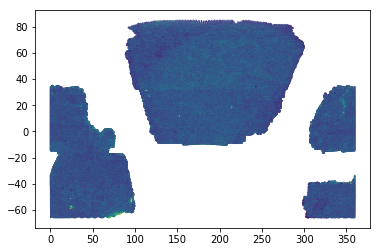

In [180]:
#let's take a look at the density
mg = len(relg)/len(felg)
print(mg)
wp = pixlr > 0
pixls = []
for i in range(0,len(pixlr)):
    if pixlr[i] > 0:
        pixls.append(i)
pixls = np.array(pixls).astype(int)        
th,phi = healpy.pix2ang(nside,pixls,nest=nest)
od = pixlg[wp]/pixlr[wp]/mg
def thphi2radec(theta,phi):
    return 180./np.pi*phi,-(180./np.pi*theta-90)
ra,dec = thphi2radec(th,phi)
plt.scatter(ra,dec,c=od,vmax=4,s=.1)
plt.show()

In [181]:
#let's define split into bmzls, DECaLS North, DECaLS South (Anand has tools to make distinct DES region as well)
def splitcat(cat):
    NN = cat['PHOTSYS'] == b'N'
    d1 = (cat['PHOTSYS'] != b'N') & (cat['RA'] < 300) & (cat['RA'] > 100) & (cat['DEC'] > -20)
    d2 = (d1==0) & (NN ==0) & (cat['DEC'] > -30)
    return cat[NN],cat[d1],cat[d2]
d1,d2,d3 = splitcat(felg)
r1,r2,r3 = splitcat(relg)

In [189]:
#turn plotting into function and plot each region separately
#could make this quicker by storing region info somewhere
def plotdens(dat,ran,nside=nside,nest=nest,wrapra=False):
    pixlr = np.zeros(12*nside*nside)
    pixlg = np.zeros(12*nside*nside)
    rth,rphi = radec2thphi(ran['RA'],ran['DEC'])
    rpix = healpy.ang2pix(nside,rth,rphi,nest=nest)
    dth,dphi = radec2thphi(dat['RA'],dat['DEC'])
    dpix = healpy.ang2pix(nside,dth,dphi,nest)
    for pix in rpix:
        pixlr[pix] += 1.
    print('randoms done')
    for pix in dpix:
        pixlg[pix] += 1.
    mg = len(ran)/len(dat)
    print(mg)
    wp = pixlr > 0
    pixls = []
    for i in range(0,len(pixlr)):
        if pixlr[i] > 0:
            pixls.append(i)
    pixls = np.array(pixls).astype(int)        
    th,phi = healpy.pix2ang(nside,pixls,nest=nest)
    od = pixlg[wp]/pixlr[wp]/mg
    def thphi2radec(theta,phi):
        return 180./np.pi*phi,-(180./np.pi*theta-90)
    ra,dec = thphi2radec(th,phi)
    ranew = ra
    if wrapra:
        w = ra > 180.
        ranew[w] -= 360
    plt.scatter(ranew,dec,c=od,vmax=4,s=.1)
    plt.show()

randoms done
0.9296606569545075


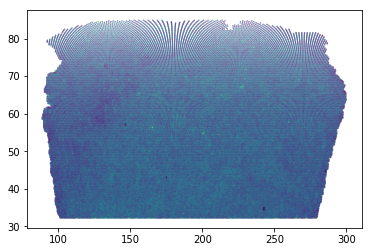

In [186]:
plotdens(d1,r1) 

randoms done
0.9516077080079189


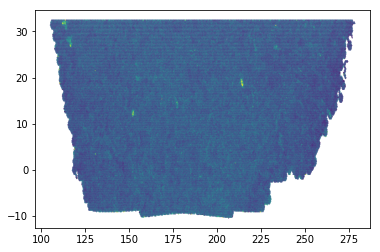

In [192]:
plotdens(d2,r2)

randoms done
0.9887929426416598


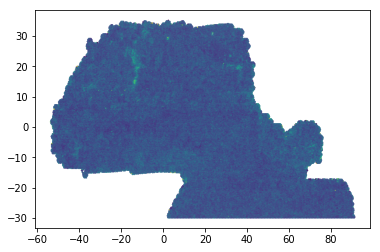

In [191]:
plotdens(d3,r3,wrapra=True)

In [40]:
def get_pixkey(hppix,key):
    return fitsio.read(pixfn,columns=key)[hppix]

In [40]:
frelg = fitsio.read('/global/cscratch1/sd/raichoor/desits_lss/dr8-0.31.1/lss-dr8-0.31.1-elg.rand.fits',rows=np.arange(1e6))
frelgh = fitsio.read_header('/global/cscratch1/sd/raichoor/desits_lss/dr8-0.31.1/lss-dr8-0.31.1-elg.rand.fits',ext=1)
frelgh


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / array data type
NAXIS   =                    2 / number of array dimensions
NAXIS1  =                   85 / length of dimension 1
NAXIS2  =            304987125 / length of dimension 2
PCOUNT  =                    0 / number of group parameters
GCOUNT  =                    1 / number of groups
TFIELDS =                   21 / number of table fields
TTYPE1  = 'RA      '
TFORM1  = 'D       '
TTYPE2  = 'DEC     '
TFORM2  = 'D       '
TTYPE3  = 'BRICKNAME'
TFORM3  = '8A      '
TTYPE4  = 'NOBS_G  '
TFORM4  = 'I       '
TTYPE5  = 'NOBS_R  '
TFORM5  = 'I       '
TTYPE6  = 'NOBS_Z  '
TFORM6  = 'I       '
TTYPE7  = 'PSFDEPTH_G'
TFORM7  = 'E       '
TTYPE8  = 'PSFDEPTH_R'
TFORM8  = 'E       '
TTYPE9  = 'PSFDEPTH_Z'
TFORM9  = 'E       '
TTYPE10 = 'GALDEPTH_G'
TFORM10 = 'E       '
TTYPE11 = 'GALDEPTH_R'
TFORM11 = 'E       '
TTYPE12 = 'GALDEPTH_Z'
TFORM12 = 'E       '
TTYPE13 = 'PSFDEPTH_W1'
TFORM13 = 'E     

In [41]:
print(len(frelg['RA']))
np.unique(frelg['RA'])


1000000


array([ 27.93674158,  99.11682193])

In [42]:
rall = fitsio.read('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',rows=np.arange(1e6)
                  )
rall_header = fitsio.read_header('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',ext=1)

In [43]:
rall_header


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / 8-bit bytes
NAXIS   =                    2 / 2-dimensional binary table
NAXIS1  =                  115 / width of table in bytes
NAXIS2  =            508311875 / number of rows in table
PCOUNT  =                    0 / size of special data area
GCOUNT  =                    1 / one data group (required keyword)
TFIELDS =                   29 / number of fields in each row
TTYPE1  = 'RA      '           / label for field   1
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE
TTYPE2  = 'DEC     '           / label for field   2
TFORM2  = 'D       '           / data format of field: 8-byte DOUBLE
TTYPE3  = 'BRICKNAME'          / label for field   3
TFORM3  = '8A      '           / data format of field: ASCII Character
TTYPE4  = 'NOBS_G  '           / label for field   4
TFORM4  = 'I       '           / data format of field: 2-byte INTEGER
TTYPE5  = 'NOBS_R  '           / label for fi

In [37]:
np.unique(rall['RA'])


array([  3.66742491e-04,   1.67202641e-03,   1.80935813e-03, ...,
         3.59998970e+02,   3.59998992e+02,   3.59999299e+02])

In [44]:
frelg = fitsio.read('/global/cscratch1/sd/raichoor/desits_lss/dr8-0.31.1/lss-dr8-0.31.1-elg.rand.fits',rows=np.arange(1e6))


In [45]:
np.unique(frelg['RA'])

array([ 27.93674158,  99.11682193])

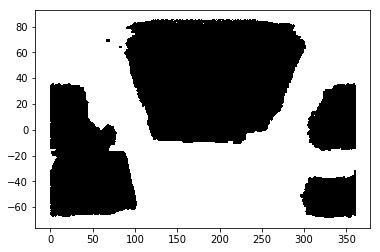

In [46]:
plt.plot(rall['RA'],rall['DEC'],'k,')
plt.show()

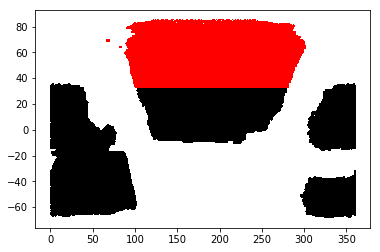

In [54]:
plt.plot(rall['RA'],rall['DEC'],'k,')
plt.plot(rall[NN]['RA'],rall[NN]['DEC'],'r,')
plt.show()

In [48]:
np.unique(rall['PHOTSYS'])

array([b'N', b'S'],
      dtype='|S1')

In [52]:
NN = rall['PHOTSYS'] == b'N'

In [53]:
len(rall[NN])

253496

In [55]:
d1 = (rall['PHOTSYS'] != b'N') & (rall['RA'] < 300) & (rall['RA'] > 100) & (rall['DEC'] > -20)

In [56]:
len(rall[d1])

292442

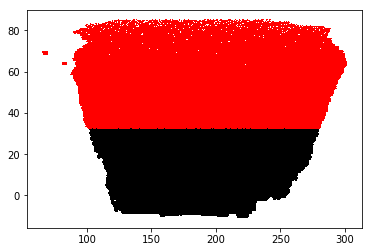

In [57]:
plt.plot(rall[d1]['RA'],rall[d1]['DEC'],'k,')
plt.plot(rall[NN]['RA'],rall[NN]['DEC'],'r,')
plt.show()

In [58]:
d2 = (d1==0) & (NN ==0) 

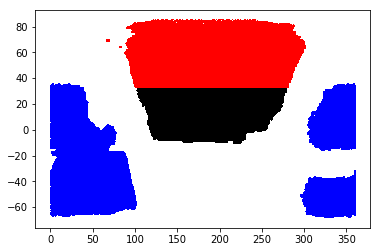

In [59]:
plt.plot(rall[d1]['RA'],rall[d1]['DEC'],'k,')
plt.plot(rall[NN]['RA'],rall[NN]['DEC'],'r,')
plt.plot(rall[d2]['RA'],rall[d2]['DEC'],'b,')
plt.show()

In [60]:
keep = (rall['NOBS_G']>0) & (rall['NOBS_R']>0) & (rall['NOBS_Z']>0)
print(len(rall[keep]))
elgbits = [1,5,6,7,11,12,13]
keepelg = keep
for bit in elgbits:
    keepelg &= ((rall['MASKBITS'] & 2**bit)==0)
print(len(rall[keepelg]))    

956051
910853


In [61]:
rall = fitsio.read('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',rows=np.arange(1e7)
                  )


In [62]:
keep = (rall['NOBS_G']>0) & (rall['NOBS_R']>0) & (rall['NOBS_Z']>0)
print(len(rall[keep]))
elgbits = [1,5,6,7,11,12,13]
keepelg = keep
for bit in elgbits:
    keepelg &= ((rall['MASKBITS'] & 2**bit)==0)
print(len(rall[keepelg]))    

9559654
9109322


In [63]:
felg = fitsio.read('/global/cscratch1/sd/raichoor/desits_lss/dr8-0.31.1/lss-dr8-0.31.1-elg.data.fits')

In [96]:
len(np.unique(felg['RA']))
keepe = (felg['NOBS_G']>0) & (felg['NOBS_R']>0) & (felg['NOBS_Z']>0)
print(len(felg[keepe]))
elgbits = [1,5,6,7,11,12,13]
keepelge = keepe
for bit in elgbits:
    keepelge &= ((felg['MASKBITS'] & 2**bit)==0)
print(len(felg[keepelge]))  

In [99]:
print(len(felg))
print(len(felg[keepelge])) 

47256516
47255413


In [65]:
relg = rall[keepelg]

In [68]:
import healpy
def radec2thphi(ra,dec):
    return (-dec+90.)*np.pi/180.,ra*np.pi/180.

In [71]:
rth,rphi = radec2thphi(relg['RA'],relg['DEC'])
rpix = healpy.ang2pix(256,rth,rphi)

In [72]:
dth,dphi = radec2thphi(felg['RA'],felg['DEC'])
dpix = healpy.ang2pix(256,dth,dphi)

In [73]:
print(len(np.unique(rpix)),len(np.unique(dpix)))

377277 377786


In [74]:
pixlr = np.zeros(12*256*256)
pixlg = np.zeros(12*256*256)


In [78]:

for pix in rpix:
    pixlr[pix] += 1.
print('randoms done')
for pix in dpix:
    pixlg[pix] += 1.


randoms done


In [79]:
mg = len(dth)/float(len(relg))
print(mg)

5.187709469486313


In [83]:
wp = pixlr > 0
pixls = []
for i in range(0,len(pixlr)):
    if pixlr[i] > 0:
        pixls.append(i)
pixls = np.array(pixls).astype(int)        
th,phi = healpy.pix2ang(256,pixls)
od = pixlg[wp]/pixlr[wp]/mg

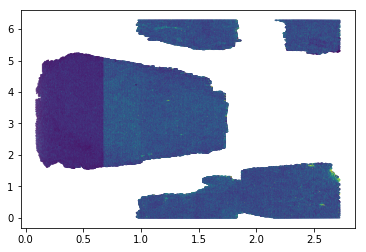

In [89]:
plt.scatter(th,phi,c=od,vmax=4,s=.1)
plt.show()

In [85]:
np.max(od)

17.348697055872677

In [86]:
np.min(od)

0.0

In [93]:
def thphi2radec(theta,phi):
    return 180./np.pi*phi,-(180./np.pi*theta-90)


In [94]:
ra,dec = thphi2radec(th,phi)

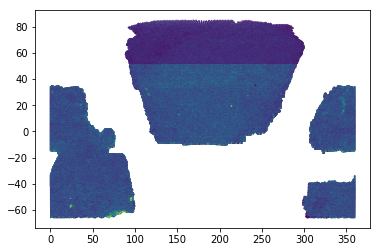

In [95]:
plt.scatter(ra,dec,c=od,vmax=4,s=.1)
plt.show()

In [102]:
frelg = fitsio.read('/global/cscratch1/sd/raichoor/desits_lss/dr8-0.31.1/lss-dr8-0.31.1-elg.rand.fits',rows=np.arange(5e7))

In [103]:
rth,rphi = radec2thphi(frelg['RA'],frelg['DEC'])
rpix = healpy.ang2pix(256,rth,rphi)

In [104]:
pixlr = np.zeros(12*256*256)
for pix in rpix:
    pixlr[pix] += 1.

In [105]:
mg = len(dth)/float(len(frelg))
print(mg)

0.94513032


In [106]:
wp = pixlr > 0
pixls = []
for i in range(0,len(pixlr)):
    if pixlr[i] > 0:
        pixls.append(i)
pixls = np.array(pixls).astype(int)        
th,phi = healpy.pix2ang(256,pixls)
od = pixlg[wp]/pixlr[wp]/mg

In [107]:
ra,dec = thphi2radec(th,phi)

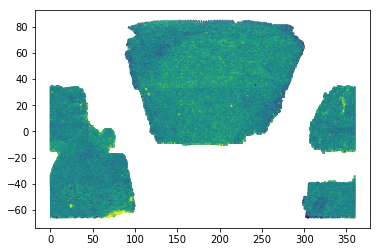

In [109]:
plt.scatter(ra,dec,c=od,vmax=2,s=.1)
plt.show()

In [110]:
felg_header = fitsio.read_header('/global/cscratch1/sd/raichoor/desits_lss/dr8-0.31.1/lss-dr8-0.31.1-elg.data.fits',ext=1)

In [111]:
felg_header


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / array data type
NAXIS   =                    2 / number of array dimensions
NAXIS1  =                   85 / length of dimension 1
NAXIS2  =             47256516 / length of dimension 2
PCOUNT  =                    0 / number of group parameters
GCOUNT  =                    1 / number of groups
TFIELDS =                   21 / number of table fields
TTYPE1  = 'RA      '
TFORM1  = 'D       '
TTYPE2  = 'DEC     '
TFORM2  = 'D       '
TTYPE3  = 'BRICKNAME'
TFORM3  = '8A      '
TTYPE4  = 'NOBS_G  '
TFORM4  = 'I       '
TTYPE5  = 'NOBS_R  '
TFORM5  = 'I       '
TTYPE6  = 'NOBS_Z  '
TFORM6  = 'I       '
TTYPE7  = 'PSFDEPTH_G'
TFORM7  = 'E       '
TTYPE8  = 'PSFDEPTH_R'
TFORM8  = 'E       '
TTYPE9  = 'PSFDEPTH_Z'
TFORM9  = 'E       '
TTYPE10 = 'GALDEPTH_G'
TFORM10 = 'E       '
TTYPE11 = 'GALDEPTH_R'
TFORM11 = 'E       '
TTYPE12 = 'GALDEPTH_Z'
TFORM12 = 'E       '
TTYPE13 = 'PSFDEPTH_W1'
TFORM13 = 'E     

In [116]:
def splitcat(cat):
    NN = cat['PHOTSYS'] == b'N'
    d1 = (cat['PHOTSYS'] != b'N') & (cat['RA'] < 300) & (cat['RA'] > 100) & (cat['DEC'] > -20)
    d2 = (d1==0) & (NN ==0) & (cat['DEC'] > -30)
    return cat[NN],cat[d1],cat[d2]

    

In [141]:
d1,d2,d3 = splitcat(felg)

In [118]:
r1,r2,r3 = splitcat(frelg)

In [119]:
print(len(d1)/len(r1),len(d2)/len(r2),len(d3)/len(r3))

0.9792356620851657 0.9568925930622876 0.9218958060674937


In [124]:
lsd = np.log(r1['STARDENS'])
r1hist = np.histogram(lsd)

In [125]:
r1hist

(array([   1572,   45298, 1029999, 4151863, 3383472, 2383190, 1353694,
         632237,   14696,      11]),
 array([ 4.33407784,  4.83001204,  5.32594624,  5.82188044,  6.31781464,
         6.81374884,  7.30968304,  7.80561724,  8.30155144,  8.79748564,
         9.29341984]))

In [126]:
lsdd = np.log(d1['STARDENS'])
d1hist = np.histogram(lsdd,bins=r1hist[1])

In [127]:
d1hist

(array([   1601,   48043, 1082328, 4288532, 3296875, 2226268, 1233304,
         537707,   11515,       5]),
 array([ 4.33407784,  4.83001204,  5.32594624,  5.82188044,  6.31781464,
         6.81374884,  7.30968304,  7.80561724,  8.30155144,  8.79748564,
         9.29341984]))

In [129]:
xl = []
for i in range(0,10):
    xl.append((d1hist[1][i]+d1hist[1][i+1])/2.)

<Container object of 3 artists>

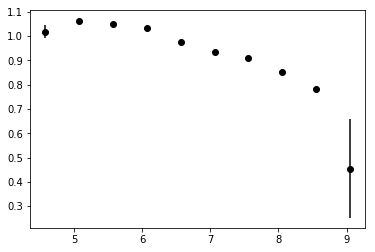

In [138]:
plt.errorbar(xl,d1hist[0]/r1hist[0],d1hist[0]**.5/r1hist[0],fmt='ko')

In [131]:
lsd = np.log(r2['STARDENS'])
r2hist = np.histogram(lsd)
lsdd = np.log(d2['STARDENS'])
d2hist = np.histogram(lsdd,bins=r2hist[1])

<Container object of 3 artists>

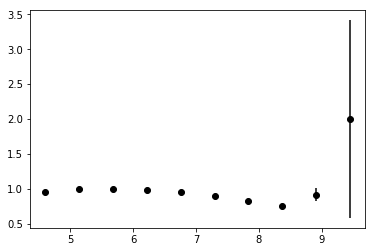

In [139]:
xl = []
for i in range(0,10):
    xl.append((d2hist[1][i]+d2hist[1][i+1])/2.)
plt.errorbar(xl,d2hist[0]/r2hist[0],d2hist[0]**.5/r2hist[0],fmt='ko')

In [133]:
lsd = np.log(r3['STARDENS'])
r3hist = np.histogram(lsd)
lsdd = np.log(d3['STARDENS'])
d3hist = np.histogram(lsdd,bins=r3hist[1])

<Container object of 3 artists>

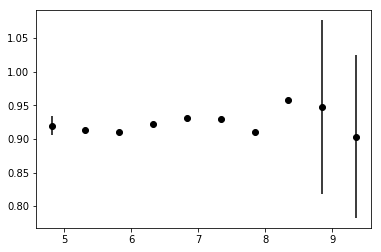

In [140]:
xl = []
for i in range(0,10):
    xl.append((d3hist[1][i]+d3hist[1][i+1])/2.)
plt.errorbar(xl,d3hist[0]/r3hist[0],d3hist[0]**.5/r3hist[0],fmt='ko')

In [135]:
r3hist[1]

array([ 4.55722141,  5.06207867,  5.56693592,  6.07179317,  6.57665043,
        7.08150768,  7.58636494,  8.09122219,  8.59607944,  9.1009367 ,
        9.60579395])